## Import Dependencies

In [84]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os

## Visualize Synthetic Data

In [85]:
def entropy_based_cluster_sizes(n_clusters, total_nodes, entropy, seed=None):
    if seed is not None:
        np.random.seed(seed)

    cluster_sizes = np.ones(n_clusters, dtype=int)  # Each cluster gets at least one node
    remaining = total_nodes - n_clusters

    if entropy == 1.0:
        # Uniform distribution
        base = remaining // n_clusters
        extra = remaining % n_clusters
        cluster_sizes += base
        for i in range(extra):
            cluster_sizes[i] += 1
    elif entropy == 0.0:
        # All remaining nodes go to one randomly chosen cluster
        idx = np.random.randint(n_clusters)
        cluster_sizes[idx] += remaining
    else:
        # Mix between entropy=0 and entropy=1
        max_alloc = int((1 - entropy) * remaining)
        min_alloc = remaining - max_alloc

        # Step 1: allocate max_alloc to one cluster
        idx = np.random.randint(n_clusters)
        cluster_sizes[idx] += max_alloc

        # Step 2: distribute min_alloc equally among others
        others = [i for i in range(n_clusters) if i != idx]
        base = min_alloc // len(others)
        extra = min_alloc % len(others)
        for i, cluster in enumerate(others):
            cluster_sizes[cluster] += base + (1 if i < extra else 0)

    return cluster_sizes


In [86]:
def generate_synthetic_signed_graph(n_clusters=3, 
                                     total_nodes=20, 
                                     entropy=0.5,
                                     noise_level=0.0, 
                                     seed=None):
    if seed is not None:
        np.random.seed(seed)

    if n_clusters > total_nodes:
        raise ValueError("Number of clusters cannot exceed total number of nodes.")

    cluster_sizes = entropy_based_cluster_sizes(n_clusters=n_clusters, total_nodes=total_nodes, entropy=entropy, seed=seed)
    
    cluster_indices = []
    node_id = 0
    for size in cluster_sizes:
        indices = list(range(node_id, node_id + size))
        cluster_indices.append(indices)
        node_id += size

    adj_matrix = np.zeros((total_nodes, total_nodes))

    for indices in cluster_indices:
        for i in indices:
            for j in indices:
                if i != j:
                    value = np.random.uniform(0.1, 1.0)
                    adj_matrix[i, j] = value
                    adj_matrix[j, i] = value

    for i in range(total_nodes):
        for j in range(total_nodes):
            if adj_matrix[i, j] == 0 and i != j:
                value = np.random.uniform(-1.0, -0.1)
                adj_matrix[i, j] = value
                adj_matrix[j, i] = value

    noise = np.random.normal(0, noise_level, size=adj_matrix.shape)
    np.fill_diagonal(adj_matrix, 0)
    adj_matrix += noise
    adj_matrix = np.clip(adj_matrix, -1.0, 1.0)

    return adj_matrix, cluster_indices


C:\Users\mysore\AppData\Local\Temp\ipykernel_222032\2024399759.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


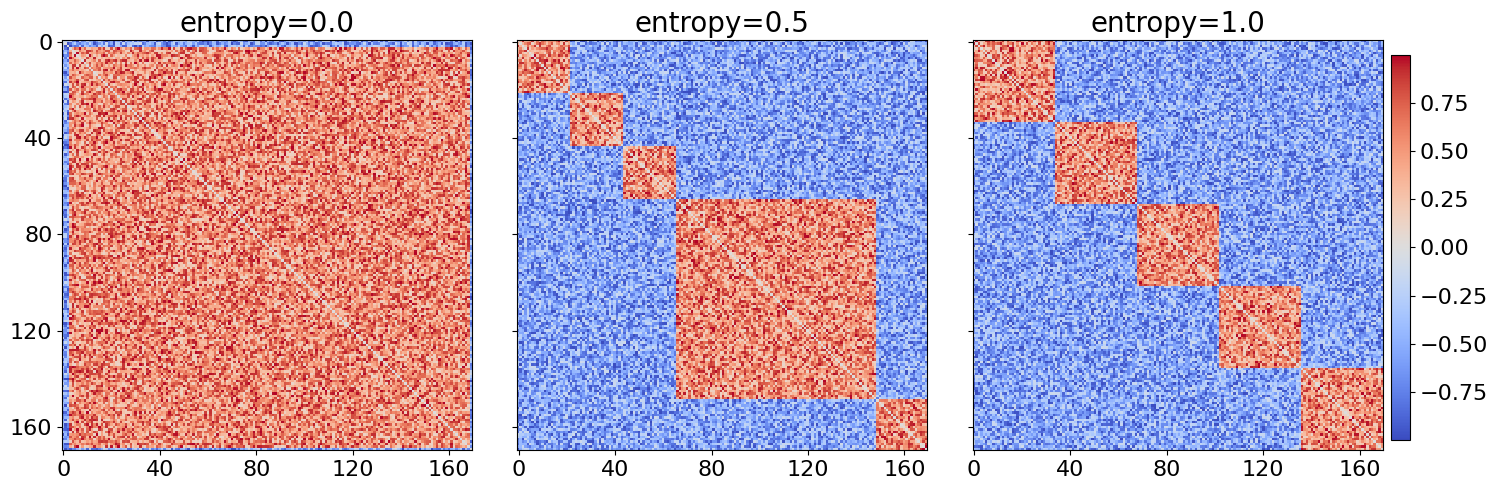

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
n_clusters = 5
total_nodes = 170
entropy_list = [0.0, 0.5, 1.0]

tick_vals = [0, 40, 80, 120, 160]

for idx, entropy in enumerate(entropy_list):
    adj_matrix, true_clusters = generate_synthetic_signed_graph(
        n_clusters=n_clusters,
        total_nodes=total_nodes,
        entropy=entropy,
        noise_level=0.00,
        seed=42
    )
    im = axes[idx].imshow(adj_matrix, cmap='coolwarm', interpolation='none')
    axes[idx].set_title(f"entropy={entropy}", fontsize=20)
    axes[idx].tick_params(axis='both', which='major', labelsize=16)
    axes[idx].set_xticks(tick_vals)
    axes[idx].set_yticks(tick_vals)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=-0.25, right=0.85)

fig.subplots_adjust(right=0.88)

fig.savefig("correlation_matrices.png", dpi=300, bbox_inches='tight')

In [ ]:
def compute_skewness_metrics(true_clusters):
    sizes = np.array([len(cluster) for cluster in true_clusters])
    total = sizes.sum()

    if total == 0:
        return {
            "gini_index": 0.0,
            "entropy": 0.0,
            "variance": 0.0,
            "std_dev": 0.0,
            "coefficient_of_variation": 0.0,
            "imbalance_ratio": 0.0,
            "range": 0,
            "skewness": 0.0,
            "kurtosis": 0.0
        }

    proportions = sizes / total

    # Gini Index
    gini_index = 1 - np.sum(proportions**2)

    # Entropy
    entropy = -np.sum([p * np.log2(p) for p in proportions if p > 0])

    # Variance and Standard Deviation
    variance = np.var(sizes)
    std_dev = np.std(sizes)

    # Coefficient of Variation (CV)
    mean = np.mean(sizes)
    cv = std_dev / mean if mean != 0 else 0.0

    # Imbalance Ratio
    imbalance_ratio = sizes.max() / sizes.min() if sizes.min() > 0 else float('inf')

    # Range
    range_val = sizes.max() - sizes.min()

    # Skewness
    skewness = ((sizes - mean)**3).mean() / (std_dev**3) if std_dev != 0 else 0.0

    # Kurtosis
    kurtosis = ((sizes - mean)**4).mean() / (std_dev**4) if std_dev != 0 else 0.0

    return {
        "gini_index": gini_index,
        "entropy": entropy,
        "variance": variance,
        "std_dev": std_dev,
        "coefficient_of_variation": cv,
        "imbalance_ratio": imbalance_ratio,
        "range": range_val,
        "skewness": skewness,
        "kurtosis": kurtosis
    }


entropy_list = [0.0, 0.5, 1.0]

for idx, entropy in enumerate(entropy_list):
    adj_matrix, true_clusters = generate_synthetic_signed_graph(
        n_clusters=n_clusters,
        total_nodes=total_nodes,
        entropy=entropy,
        noise_level=0.00,
        seed=42
    )

    print(f"\n\nEntropy: {entropy}")
    metrics = compute_skewness_metrics(true_clusters)
    print(f"Gini Index: {metrics['gini_index']:.4f}")
    print(f"Entropy: {metrics['entropy']:.4f}")
    print(f"Variance: {metrics['variance']:.4f}")
    print(f"Standard Deviation: {metrics['std_dev']:.4f}")
    print(f"Coefficient of Variation: {metrics['coefficient_of_variation']:.4f}")
    print(f"Imbalance Ratio: {metrics['imbalance_ratio']:.4f}")
    print(f"Range: {metrics['range']:.4f}")
    print(f"Skewness: {metrics['skewness']:.4f}")
    print(f"Kurtosis: {metrics['kurtosis']:.4f}")

## Combine and Filter results

In [ ]:
# # Read the CSV files
# df_quantum = pd.read_csv(r'results/log_quantum.csv')
# df_classical = pd.read_csv(r'results/log_classical.csv')

# # Merge the dataframes on the specified columns
# combined_df = pd.merge(
#     df_quantum,
#     df_classical,
#     on=["seed", "total_nodes", "n_clusters", "entropy"],
#     suffixes=('_quantum', '_classical')
# )

# combined_df = combined_df.drop(columns=['true_clusters_classical', 'true_labels_classical'])

# combined_df = combined_df.rename(columns={
#     'true_clusters_quantum': 'true_clusters',
#     'true_labels_quantum': 'true_labels'
# })

# combined_df.to_csv(r'results/log_consolidated.csv', index=False)

In [ ]:
# solvers = ['GCSQ', 'PAM', 'DIANA', 'KMeans', 'Hier', 'Spectral']

# metrics = ['NMI', 'Modularity']

# filtered_columns = ['seed', 'total_nodes', 'n_clusters', 'entropy']
# for solver in solvers:
#     for metric in metrics:
#         filtered_columns.append(f"{solver}_{metric}")


# filtered_df = combined_df[filtered_columns]
# filtered_df

# filtered_df.to_csv(r'results/results_nmi_modularity.csv', index=False)

## Generate Plots

#### Synthetic Data

In [229]:
def plot_metric_across_nodes(df, metric, algorithms, title=None, save_as=None):
    plt.figure(figsize=(10, 6))
    grouped = df.groupby("total_nodes")

    # Use distinct colors for each algorithm
    colors = plt.get_cmap("tab10")  # tab10 has 10 distinct, colorblind-friendly colors
    color_map = {algo: colors(i % 10) for i, algo in enumerate(algorithms)}

    for algo in algorithms:
        means = grouped[f"{algo}_{metric}"].mean()
        stds = grouped[f"{algo}_{metric}"].std()
        mins = grouped[f"{algo}_{metric}"].min()
        maxs = grouped[f"{algo}_{metric}"].max()
        nodes = means.index

        color = color_map[algo]

        plt.plot(nodes, means, label=algo, color=color)
        plt.fill_between(nodes, means - stds, means + stds, alpha=0.2, color=color)
        plt.plot(nodes, mins, linestyle='dotted', alpha=0.5, color=color)
        plt.plot(nodes, maxs, linestyle='dotted', alpha=0.5, color=color)

    plt.xlabel("Number of Nodes")
    plt.ylabel(metric)
    plt.title(title or f"{metric} vs Number of Nodes")
    plt.legend()
    plt.grid(True)
    if save_as:
        plt.savefig(save_as, bbox_inches='tight')
    plt.show()


In [236]:
def plot_metric_grid_across_nodes(df, algorithms, metrics, n_clusters_list, entropies, color_map=None):
    num_rows = len(entropies)
    num_cols = len(n_clusters_list)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows), sharex=True, sharey=True)
    axes = np.array(axes)

    if color_map is None:
        # Set up color palette for algorithms
        colors = plt.get_cmap("tab10")
        color_map = {algo: colors(i % 10) for i, algo in enumerate(algorithms)}

    for i, entropy in enumerate(entropies):
        for j, k in enumerate(n_clusters_list):
            ax = axes[i, j] if num_rows > 1 else axes[j]
            df_e = df[df["entropy"] == entropy]
            df_k = df_e[df_e["n_clusters"] == k]
            grouped = df_k.groupby("total_nodes")

            for algo in algorithms:
                for metric in metrics:
                    col = f"{algo}_{metric}"
                    if col not in df.columns:
                        continue

                    means = grouped[col].mean()
                    stds = grouped[col].std()
                    mins = grouped[col].min()
                    maxs = grouped[col].max()
                    nodes = means.index
                    color = color_map[algo]

                    ax.plot(nodes, means, label=algo, color=color)
                    ax.fill_between(nodes, means - stds, means + stds, alpha=0.2, color=color)
                    ax.plot(nodes, mins, linestyle='dotted', alpha=0.5, color=color)
                    ax.plot(nodes, maxs, linestyle='dotted', alpha=0.5, color=color)

            ax.set_ylim(-0.1, 1.1)
            if i == 0:
                ax.set_title(f"k = {k}", fontsize=18)
            if j == 0:
                ax.set_ylabel(f"$entropy$={entropy}\n", fontsize=20)
            ax.grid(True)
            ax.tick_params(axis='both', which='major', labelsize=16)

    # Global legend at the bottom with thicker lines
    handles, labels = ax.get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc="lower center", ncol=len(algorithms), frameon=False, fontsize=20)
    for line in legend.get_lines():
        line.set_linewidth(10)  # Set legend line thickness

    fig.suptitle("Normalized Mutual Information", fontsize=24, y=1.005)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    fig.savefig("nmi_grid_plot.png", dpi = 300, bbox_inches='tight')
    plt.show()


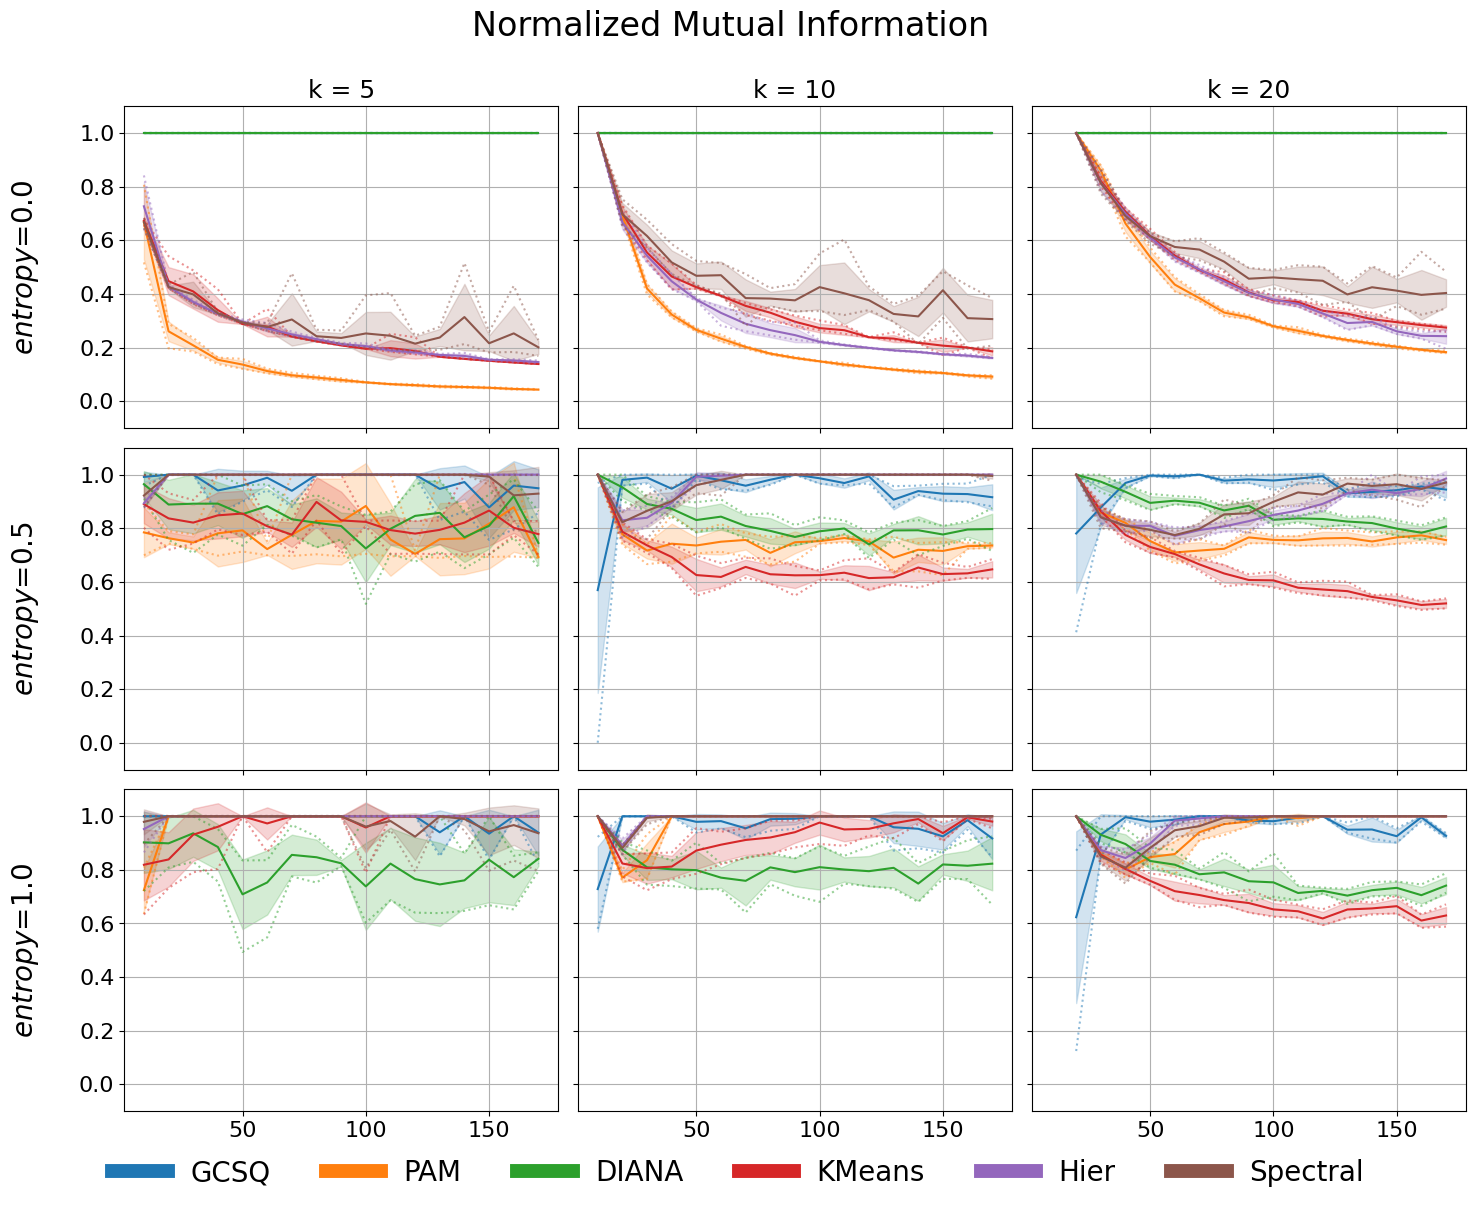

In [ ]:
# Load your experiment results
df = pd.read_csv(r"results/results_nmi_modularity.csv")

algos = ['GCSQ', 'PAM', 'DIANA', 'KMeans', 'Hier', 'Spectral']

# Custom color map: GCSQ is highlighted, others are baseline colors
algo_colors = {
    'GCSQ': "#2ca02c",      # blue (highlighted, classic matplotlib blue)
    'PAM': "#ff7f0e",       # orange
    'DIANA': "#1f77b4",     # green
    'KMeans': "#d62728",    # red
    'Hier': "#9467bd",      # purple
    'Spectral': "#8c564b"   # brown
}
metrics = ["NMI"]
n_clusters_list = [5, 10, 20]
entropies = [0.0, 0.5, 1.0]

plot_metric_grid_across_nodes(df, algos, metrics, n_clusters_list, entropies, color_map=None)

#### EO Data

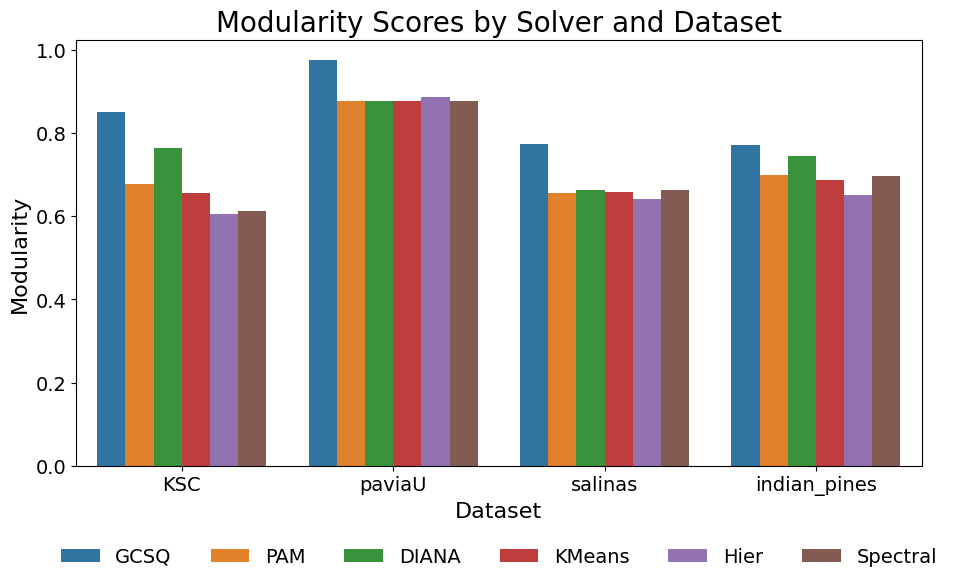

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the results from the CSV file
results_df = pd.read_csv(r'results/results_EO.csv')

# Normalize a DataFrame
def normalize(df):
    return (df - df.min().min()) / (df.max().max() - df.min().min())


plt.figure(figsize=(10, 6))
order = ['GCSQ', 'PAM', 'DIANA', 'KMeans', 'Hier', 'Spectral']
sns.barplot(data=results_df, x='Dataset', y='Modularity', hue='Solver', hue_order=order)
plt.title('Modularity Scores by Solver and Dataset', fontsize=20)
plt.ylabel('Modularity', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(np.unique(results_df.Solver)), fontsize=14, frameon=False, title_fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('EO_results.png', dpi=300, bbox_inches='tight')
plt.show()

